In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TensorFlow to use CPU
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
#Проверка, что GPU не используется:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # Должно вывести 0


Num GPUs Available:  0


In [28]:
# --- 1. Data Generation ---
def create_image_and_label(nx, ny, cnt = 15, r_min = 5, r_max = 50, border = 30, sigma = 20, rectangles=False): # Уменьшаем border
    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny), dtype=bool)  #Метки теперь 2D (HxW)

    # Add these checks!  Crucial for stability
    if border >= nx // 2 or border >= ny // 2: #Check if border is too big. Use integer division
        border = min(nx // 4, ny // 4) #Reduce to 1/4 of smallest dimension.  Must be integer.
        print(f"Warning: Border was too large, reducing to {border}")
    if r_min >= r_max:
        r_min, r_max = r_max, r_min
        print(f"Warning: r_min was >= r_max, swapping values.")

    for _ in range(cnt):
        try:
            a = np.random.randint(border, nx-border)
        except ValueError as e:
            print(f"Error generating 'a': border={border}, nx={nx}, nx-border={nx-border}")
            raise e  #Re-raise the exception to stop execution
        try:
            b = np.random.randint(border, ny-border)
        except ValueError as e:
            print(f"Error generating 'b': border={border}, ny={ny}, ny-border={ny-border}")
            raise e

        try:
            r = np.random.randint(r_min, r_max)
        except ValueError as e:
            print(f"Error generating 'r': r_min={r_min}, r_max={r_max}")
            raise e


        h = np.random.randint(1,255) # This is safe, no need for try-except

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r

        image[m] = h
        label[m] = True # Label = 1 inside the circle


    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    return image, label.astype(np.float32) #Return float32

In [30]:
class GrayScaleDataProvider(object): # Упрощенный DataProvider
    def __init__(self, nx, ny, cnt=10, batch_size = 32):
        self.nx = nx
        self.ny = ny
        self.cnt = cnt
        self.batch_size = batch_size


    def __call__(self, n):
        images = []
        labels = []
        for i in range(n):
            img, lbl = create_image_and_label(self.nx, self.ny, cnt=self.cnt)
            images.append(img)
            labels.append(lbl)
        return np.array(images), np.array(labels)

# --- 2. Create Dataset & Split  ---
nx = 128  
ny = 128
num_samples = 500 # Увеличиваем размер выборки
generator = GrayScaleDataProvider(nx, ny, cnt=10) #Больше кругов

X, Y = generator(num_samples)

#Reshape для TensorFlow
X = X.reshape(-1, nx, ny, 1)
Y = Y.reshape(-1, nx, ny, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Train size: 320, Validation size: 80, Test size: 100


In [32]:
# --- 3. Define UNet Model ---
def build_unet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)  # Уменьшаем фильтры
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)  # Уменьшаем фильтры
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) # Уменьшаем фильтры

    # Decoder
    up4 = layers.UpSampling2D((2, 2))(conv3)
    merge4 = layers.concatenate([conv2, up4], axis=-1)
    conv4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge4) # Уменьшаем фильтры

    up5 = layers.UpSampling2D((2, 2))(conv4)
    merge5 = layers.concatenate([conv1, up5], axis=-1)
    conv5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(merge5) # Уменьшаем фильтры

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5) #Sigmoid for binary segmentation

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (nx, ny, 1)
model = build_unet(input_shape)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.6715 - loss: 0.6302 - val_accuracy: 0.6785 - val_loss: 0.5513
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.6586 - loss: 0.5421 - val_accuracy: 0.6785 - val_loss: 0.4887
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.6670 - loss: 0.4907 - val_accuracy: 0.6791 - val_loss: 0.4525
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.6646 - loss: 0.4551 - val_accuracy: 0.7676 - val_loss: 0.3835
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.8236 - loss: 0.3706 - val_accuracy: 0.9117 - val_loss: 0.2940
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9323 - loss: 0.2594 - val_accuracy: 0.9130 - val_loss: 0.2248
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.9341 - loss: 0.1980 - val_accuracy: 0.9012 - val_loss: 0.2339
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.9256 - loss: 0.1937 - val_accuracy: 0.

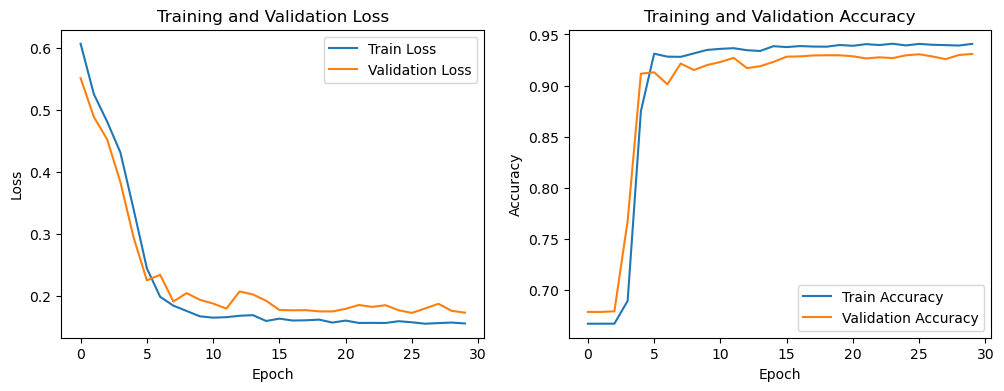

In [34]:
# --- 4. Compile Model ---

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# --- 5. Train Model ---
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=30) #Уменьшаем batch_size, увеличиваем epochs

# --- 6. Evaluate Model on Test Set ---
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# --- 7. Plot Training History ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


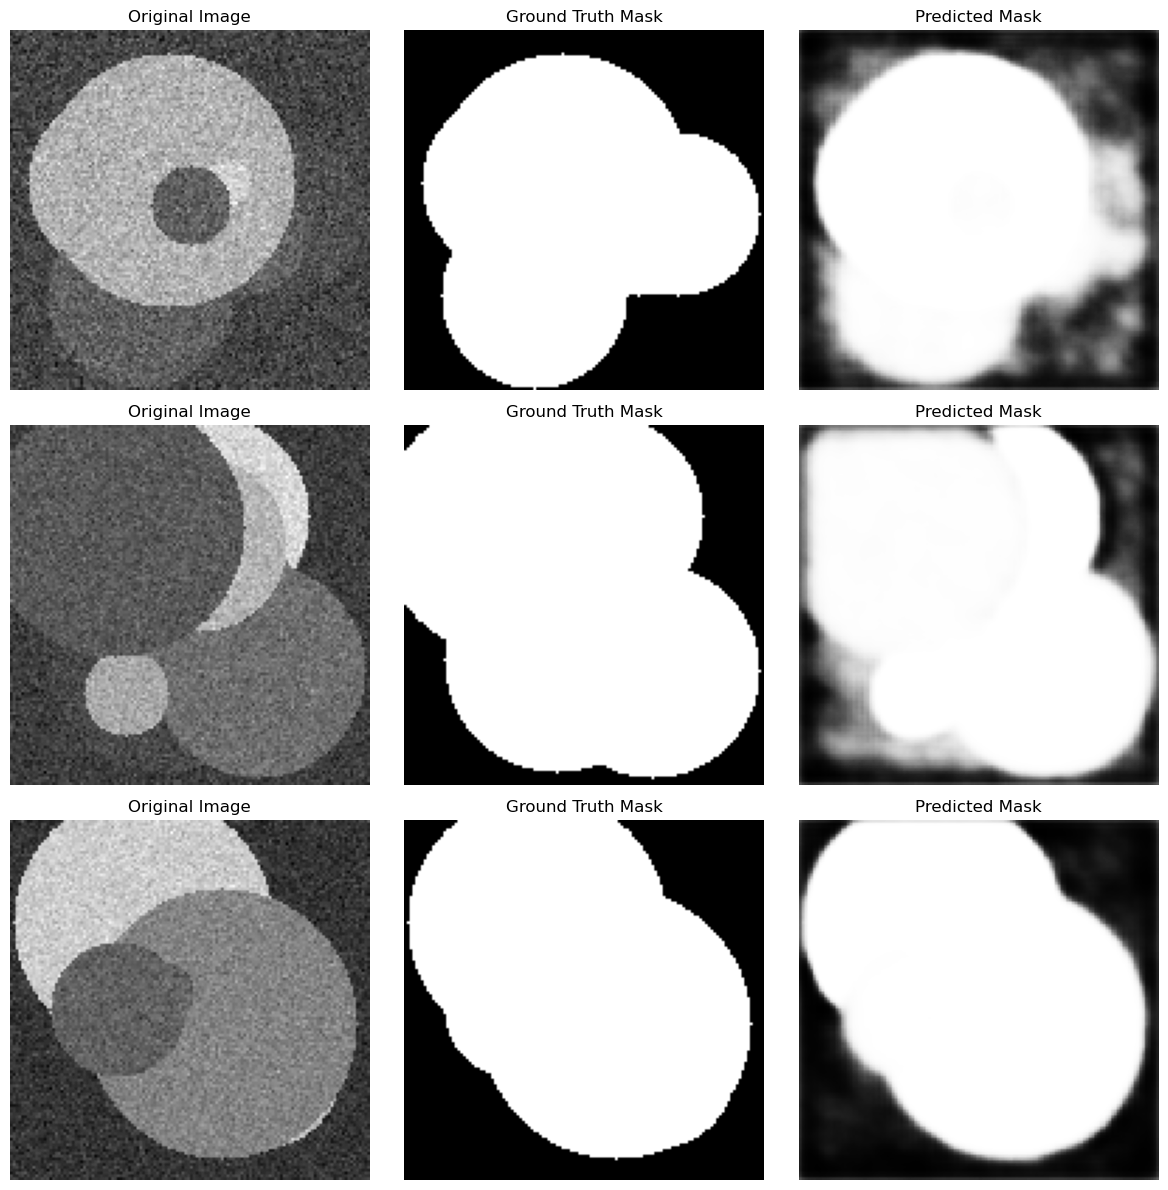

In [35]:
# --- 8. Make Predictions and Visualize (Optional) ---
# Select a few random images from the test set
num_images = 3
random_indices = np.random.choice(len(X_test), num_images, replace=False)
sample_images = X_test[random_indices]
sample_labels = Y_test[random_indices]

# Make predictions on the sample images
predicted_masks = model.predict(sample_images)

# Visualize the results
fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
for i in range(num_images):
    # Original image
    axes[i, 0].imshow(sample_images[i, ..., 0], cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Ground truth mask
    axes[i, 1].imshow(sample_labels[i, ..., 0], cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 1].axis('off')

    # Predicted mask
    axes[i, 2].imshow(predicted_masks[i, ..., 0], cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()